In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# for MPC's STAC catalog search
import pystac_client
import planetary_computer

import contextily as ctx #for adding basemaps

We use the 2020 US Census Collection id `us-census` to look for the data in the MPC catalog.

This collection has each tabular file as an item:

In [5]:
# open MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# search whole collection for census collection
search = catalog.search(collections=["us-census"])

# retrieve items
items = {item.id : item for item in search.items()}
list(items)

['2020-census-blocks-population',
 '2020-census-blocks-geo',
 '2020-cb_2020_us_vtd_500k',
 '2020-cb_2020_us_unsd_500k',
 '2020-cb_2020_us_ttract_500k',
 '2020-cb_2020_us_tract_500k',
 '2020-cb_2020_us_tbg_500k',
 '2020-cb_2020_us_state_500k',
 '2020-cb_2020_us_sldu_500k',
 '2020-cb_2020_us_sldl_500k',
 '2020-cb_2020_us_scsd_500k',
 '2020-cb_2020_us_region_500k',
 '2020-cb_2020_us_place_500k',
 '2020-cb_2020_us_nectadiv_500k',
 '2020-cb_2020_us_necta_500k',
 '2020-cb_2020_us_nation_5m',
 '2020-cb_2020_us_metdiv_500k',
 '2020-cb_2020_us_elsd_500k',
 '2020-cb_2020_us_division_500k',
 '2020-cb_2020_us_csa_500k',
 '2020-cb_2020_us_cousub_500k',
 '2020-cb_2020_us_county_within_cd116_500k',
 '2020-cb_2020_us_county_500k',
 '2020-cb_2020_us_concity_500k',
 '2020-cb_2020_us_cnecta_500k',
 '2020-cb_2020_us_cd116_500k',
 '2020-cb_2020_us_cbsa_500k',
 '2020-cb_2020_us_bg_500k',
 '2020-cb_2020_us_aitsn_500k',
 '2020-cb_2020_us_aiannh_500k',
 '2020-cb_2020_72_subbarrio_500k',
 '2020-cb_2020_02_anrc_

In [8]:
item = items['2020-cb_2020_us_county_500k']
item

<Item id=2020-cb_2020_us_county_500k>

Notice each item has a single asset 'data'. This contains the URL to the GeoParquet file holding the information. Let's access the item's asset:

In [9]:
asset = item.assets['data']
asset

<Asset href=abfs://us-census/2020/cb_2020_us_county_500k.parquet>

## Opening (Geo)Parquet
To open the parquet file we use the `gpd.read_parquet()` function using the asset's URL pointing to the data:

In [10]:
counties = gpd.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)

In [12]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."


In [13]:
# now a regular GeoDataFrame!
type(counties)

geopandas.geodataframe.GeoDataFrame

## Contextily

This is a Python library to add basemaps.

Retrieves tile maps from the tinternet and makes it possible to plot them alongside our vector data.

**Example**

We want to plot the Santa Barbara county polygon together with a basemap.

In [15]:
sb = counties[counties.NAME == 'Santa Barbara']
sb

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
1222,06,083,00277306,0500000US06083,06083,Santa Barbara,Santa Barbara County,CA,California,06,7080860393,2729213352,"MULTIPOLYGON (((-119.04704 33.48382, -119.0384..."


<Axes: >

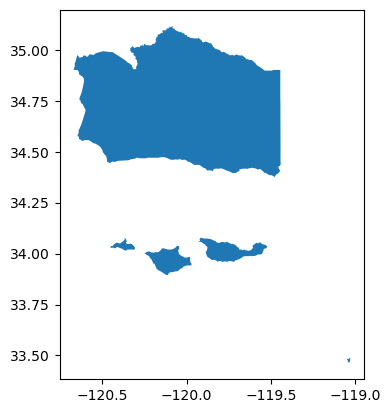

In [16]:
sb.plot()

Contextily's tiles can be reprojected to match the CRS of our vector data, but...

...it can be easier to reproject your vector to EPSG 3857 instead.

The CRS EPSG 3857 iss a projected CRS used for rendering maps online. For example in Google Maps or OpenStreet maps.

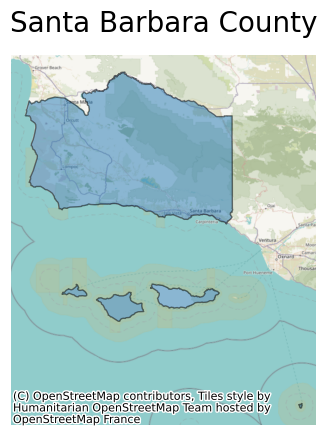

In [18]:
fig, ax = plt.subplots()

(sb.to_crs(epsg=3857)
 .plot(ax = ax, figsize = (7,7), alpha = 0.5, edgecolor = 'k'))

# add basemap
ctx.add_basemap(ax=ax)

ax.set_title('Santa Barbara County', fontdict = {'fontsize':'20'})
ax.set_axis_off()

By default, contextily uses the OpenStreetMap HOT style. We can change basemaps by updating the `source` parameter in the `add_basemap()` function. For example:

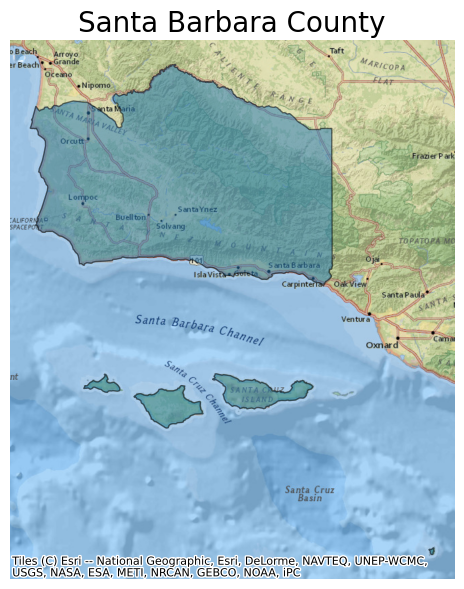

In [19]:
# create axis with plot
ax = (sb.to_crs(epsg=3857)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Santa Barbara County", fontdict={"fontsize": "20"})
ax.set_axis_off()

Checking ctx.providers we can see the basemaps available:

In [20]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 